In [1]:
# Cook
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure


In [2]:
import cv2


In [3]:
# Load MNIST dataset from TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

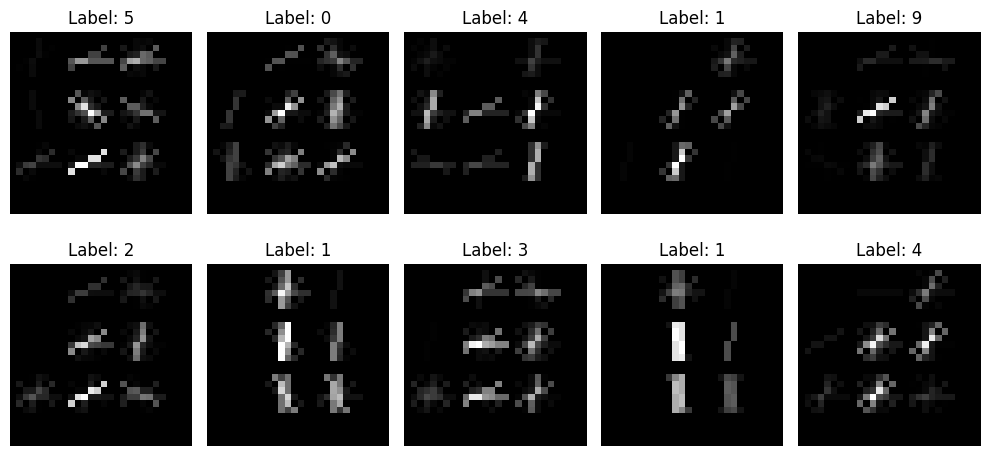

In [4]:

# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    hog_images = []
    
    for image in images:
        # Compute HOG features
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(3, 3), visualize=True) # multichannel=False
        
        hog_features.append(fd)
        hog_images.append(hog_image)
    
    return np.array(hog_features), np.array(hog_images)

# Extract HOG features for training and testing data
x_train_hog, x_train_hog_images = extract_hog_features(x_train)
x_test_hog, x_test_hog_images = extract_hog_features(x_test)

# Visualize some HOG images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_hog_images[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import numpy as np


In [8]:
x_train_hog.shape

(60000, 81)

In [9]:
# Normalize features
scaler = StandardScaler()
train_hog = scaler.fit_transform(x_train_hog)
test_hog = scaler.transform(x_test_hog)


In [16]:
type(train_hog[0])

numpy.ndarray

In [14]:
len(train_hog)

60000

In [15]:
len(test_hog)

10000

In [19]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Assuming train_hog and test_hog are your datasets with shape (60000, 9, 9) and (10000, 9, 9)

# Flatten the datasets
train_hog_flat = train_hog.reshape(train_hog.shape[0], -1)  # Shape: (60000, 81)
test_hog_flat = test_hog.reshape(test_hog.shape[0], -1)    # Shape: (10000, 81)

# Build a k-NN graph using the test set
n_neighbors = 5
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(test_hog_flat)  # Fit k-NN on the test set

# Generate the adjacency matrix for the test set based on its own k-NN graph
W = knn.kneighbors_graph(test_hog_flat, mode='connectivity')

# Convert to sparse matrix format
W = csr_matrix(W)

# Compute the degree matrix for the test set
D = np.diag(np.array(W.sum(axis=1)).flatten())

# Verify shapes
print(f"Shape of W: {W.shape}")  # Should be (10000, 10000)
print(f"Shape of D: {D.shape}")  # Should be (10000, 10000)

# Compute the graph Laplacian for the test set
L = D - W

# Ensure L is symmetric
L = (L + L.T) / 2

# Compute the smallest eigenvectors of the Laplacian
n_bits = 32  # Number of bits in the hash code
_, eigenvectors = eigsh(L, k=n_bits, which='SM')

# Binarize the eigenvectors to form the hash codes
hash_codes_hog = (eigenvectors > 0).astype(int)

# Output the generated hash codes
print("Generated hash codes:")
print(hash_codes_hog)


Shape of W: (10000, 10000)
Shape of D: (10000, 10000)
Generated hash codes:
[[0 1 1 ... 0 1 1]
 [1 0 1 ... 0 1 1]
 [1 1 1 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [0 0 1 ... 1 1 0]
 [0 1 1 ... 0 0 0]]


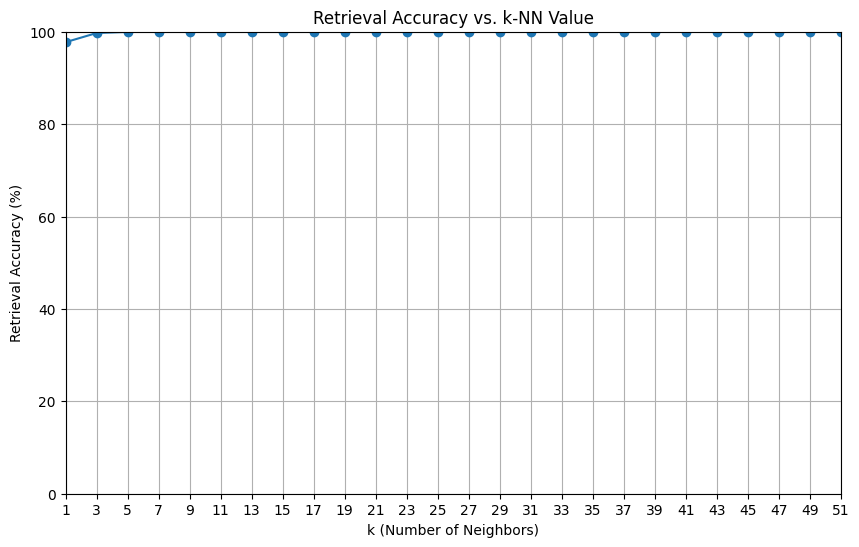

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Benchmarking Retrieval Accuracy for multiple values of k
def retrieval_accuracy(test_hash_codes, test_labels, k_values):
    accuracies = {}
    
    for k in k_values:
        # Use k-NN on hash codes
        knn_retrieval = NearestNeighbors(n_neighbors=k)
        knn_retrieval.fit(test_hash_codes)
        
        # Find nearest neighbors for each test sample
        distances, indices = knn_retrieval.kneighbors(test_hash_codes)
        
        # Calculate accuracy
        retrieved_labels = test_labels[indices]  # Indices has shape (n_samples, k)
        
        # Check if the true label is in the retrieved labels
        correct_predictions = np.sum(retrieved_labels == test_labels[:, np.newaxis], axis=1)  # Shape (n_samples,)
        accuracy = np.mean(correct_predictions > 0) * 100  # Calculate percentage
        
        accuracies[k] = accuracy
    
    return accuracies

# Specify k values to test: odd numbers from 1 to 51
k_values = list(range(1, 52, 2))

# Calculate accuracies for different k values
accuracies = retrieval_accuracy(hash_codes_hog, y_test, k_values)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(accuracies.keys(), accuracies.values(), marker='o')
plt.title('Retrieval Accuracy vs. k-NN Value')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Retrieval Accuracy (%)')
plt.xticks(k_values)  # Show all k values on x-axis
plt.grid()
plt.xlim(1, 51)
plt.ylim(0, 100)
plt.show()


Retrieval Accuracy (k=1): 97.74%
Retrieval Accuracy (k=3): 99.72%
Retrieval Accuracy (k=5): 99.96%
Retrieval Accuracy (k=7): 99.98%
Retrieval Accuracy (k=9): 100.00%
Retrieval Accuracy (k=11): 100.00%
Retrieval Accuracy (k=13): 100.00%
Retrieval Accuracy (k=15): 100.00%
Retrieval Accuracy (k=17): 100.00%
Retrieval Accuracy (k=19): 100.00%
Retrieval Accuracy (k=21): 100.00%
Retrieval Accuracy (k=23): 100.00%
Retrieval Accuracy (k=25): 100.00%
Retrieval Accuracy (k=27): 100.00%
Retrieval Accuracy (k=29): 100.00%
Retrieval Accuracy (k=31): 100.00%
Retrieval Accuracy (k=33): 100.00%
Retrieval Accuracy (k=35): 100.00%
Retrieval Accuracy (k=37): 100.00%
Retrieval Accuracy (k=39): 100.00%
Retrieval Accuracy (k=41): 100.00%
Retrieval Accuracy (k=43): 100.00%
Retrieval Accuracy (k=45): 100.00%
Retrieval Accuracy (k=47): 100.00%
Retrieval Accuracy (k=49): 100.00%
Retrieval Accuracy (k=51): 100.00%


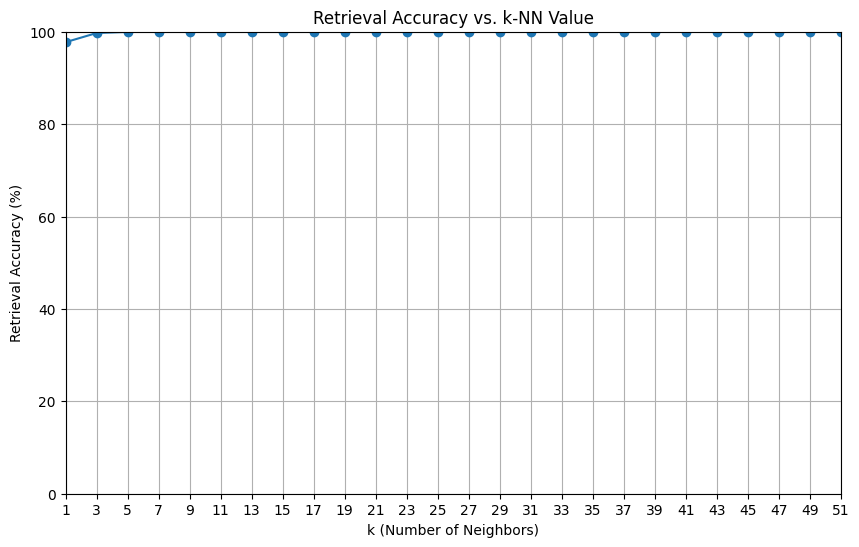

In [41]:
# Benchmarking Retrieval Accuracy for multiple values of k
def retrieval_accuracy(test_hash_codes, test_labels, k_values):
    accuracies = {}
    
    for k in k_values:
        # Use k-NN on hash codes
        knn_retrieval = NearestNeighbors(n_neighbors=k)
        knn_retrieval.fit(test_hash_codes)
        
        # Find nearest neighbors for each test sample
        distances, indices = knn_retrieval.kneighbors(test_hash_codes)
        
        # Calculate accuracy based on correct retrievals
        retrieved_labels = test_labels[indices]  # Indices has shape (n_samples, k)
        
        # Check if the true label is in the retrieved labels for each sample
        correct_retrievals = np.any(retrieved_labels == test_labels[:, np.newaxis], axis=1)  # Shape (n_samples,)
        
        # Calculate the percentage of correct retrievals
        accuracy = np.mean(correct_retrievals) * 100  # Calculate percentage
        accuracies[k] = accuracy
    
    return accuracies

# Specify k values to test: odd numbers from 1 to 51
k_values = list(range(1, 52, 2))

# Calculate accuracies for different k values
accuracies = retrieval_accuracy(hash_codes_hog, y_test, k_values)

# Print the accuracies
for k, accuracy in accuracies.items():
    print(f"Retrieval Accuracy (k={k}): {accuracy:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(accuracies.keys(), accuracies.values(), marker='o')
plt.title('Retrieval Accuracy vs. k-NN Value')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Retrieval Accuracy (%)')
plt.xticks(k_values)  # Show all k values on x-axis
plt.grid()
plt.xlim(1, 51)
plt.ylim(0, 100)
plt.show()

In [40]:
accuracies

{1: 97.74000000000001,
 3: 99.72,
 5: 99.96000000000001,
 7: 99.98,
 9: 100.0,
 11: 100.0,
 13: 100.0,
 15: 100.0,
 17: 100.0,
 19: 100.0,
 21: 100.0,
 23: 100.0,
 25: 100.0,
 27: 100.0,
 29: 100.0,
 31: 100.0,
 33: 100.0,
 35: 100.0,
 37: 100.0,
 39: 100.0,
 41: 100.0,
 43: 100.0,
 45: 100.0,
 47: 100.0,
 49: 100.0,
 51: 100.0}

In [36]:
# Benchmarking Retrieval Accuracy
def retrieval_accuracy(test_hash_codes, test_labels):
    # Use k-NN on hash codes
    knn_retrieval = NearestNeighbors(n_neighbors=1)
    knn_retrieval.fit(test_hash_codes)
    
    # Find nearest neighbors for each test sample
    distances, indices = knn_retrieval.kneighbors(test_hash_codes)
    
    # Calculate accuracy
    retrieved_labels = test_labels[indices.flatten()]
    accuracy = np.mean(retrieved_labels == test_labels) * 100
    return accuracy

accuracy = retrieval_accuracy(hash_codes_hog, y_test)
print(f"Retrieval Accuracy: {accuracy:.2f}%")


Retrieval Accuracy: 97.74%


In [ ]:
# I hope this is good. 

# Raw images

In [31]:
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten the images: shape becomes (60000, 784) and (10000, 784)
train_images = x_train.reshape(x_train.shape[0], -1)  # Shape: (60000, 784)
test_images = x_test.reshape(x_test.shape[0], -1)      # Shape: (10000, 784)

# Build a k-NN graph using the training set
n_neighbors = 5
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(test_images)  # Fit k-NN on the training set

# Generate the adjacency matrix for the test set based on its own k-NN graph
W = knn.kneighbors_graph(test_images, mode='connectivity')

# Convert to sparse matrix format
W = csr_matrix(W)

# Compute the degree matrix for the test set
D = np.diag(np.array(W.sum(axis=1)).flatten())

# Compute the graph Laplacian for the test set
L = D - W
L = (L + L.T) / 2  # Ensure the matrix is symmetric

# Compute the smallest eigenvectors of the Laplacian
n_bits = 32  # Number of bits in the hash code
_, eigenvectors = eigsh(L, k=n_bits, which='SM')

# Binarize the eigenvectors to form the hash codes
hash_codes_raw = (eigenvectors > 0).astype(int)

In [38]:
import json

# Example: hash_codes is your NumPy array of shape (10000, 32)
# Convert hash codes to a list
hash_codes_list = hash_codes_raw.tolist()  # Convert to a regular list

# Define the file name
json_file_name = r'C:\Users\Test\Desktop\p7\Spectral\hash_codes_raw\hash_codes.json'

# Save to a JSON file
with open(json_file_name, 'w') as json_file:
    json.dump(hash_codes_list, json_file)

print(f"Hash codes saved to {json_file_name}")

Hash codes saved to C:\Users\Test\Desktop\p7\Spectral\hash_codes_raw\hash_codes.json


In [37]:
hash_codes_raw

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 0, 1]])

In [34]:

accuracy = retrieval_accuracy(hash_codes_raw, y_test)
print(f"Retrieval Accuracy for raw data: {accuracy:.2f}%")


Retrieval Accuracy for raw data: 98.87%


In [ ]:
# Calculate accuracies for different k values
accuracies = retrieval_accuracy(hash_codes_raw, y_test, k_values)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(accuracies.keys(), accuracies.values(), marker='o')
plt.title('Retrieval Accuracy vs. k-NN Value')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Retrieval Accuracy (%)')
plt.xticks(k_values)  # Show all k values on x-axis
plt.grid()
plt.xlim(1, 51)
plt.ylim(0, 100)
plt.show()


In [33]:
# IDEAS FOR VALIDATION: 
# - k means (centroids,medoids, etc.)
# - KNN for the hash codes ( with incrementing k, should also tell how good the clustering)

# SIFT

In [ ]:
# NOW DOING THE SAME FOR SIFT, 
# WE NEED AN EXTRA STEP OF PREPROCESSING, DUE TO SIFT CREATING 60000 X 5 X 128 LIST OF LISTS FOR TRAINING, 

In [ ]:
# Initialize SIFT
sift = cv2.SIFT_create()
def apply_sift(images):
    sift_features = []
    keypoints_list = []
    for img in images[:5]:  # Only process first 5 records
        # Convert to uint8 format for OpenCV
        img = img.astype(np.uint8)
        # Detect keypoints and descriptors using SIFT
        keypoints, descriptors = sift.detectAndCompute(img, None)
        
        if descriptors is not None:
            sift_features.append(descriptors)
        else:
            sift_features.append(np.array([]))
        
        keypoints_list.append(keypoints)
    
    return sift_features, keypoints_list

# Apply SIFT to the first 5 training images
sift_train_features, keypoints_train = apply_sift(x_train)

# Plot the first 5 images with their SIFT keypoints
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(x_train[i], keypoints_train[i], None, color=(0, 255, 0))
    
    # Display the image with keypoints
    axs[i].imshow(img_with_keypoints, cmap='gray')
    axs[i].set_title(f"Label: {y_train[i]}")
    axs[i].axis('off')

plt.show()

In [ ]:
# SIFT


# Initialize SIFT
sift = cv2.SIFT_create()

def apply_sift(images):
    sift_features = []
    for img in images:
        # Convert to uint8 format for OpenCV
        img = img.astype(np.uint8)
        # Detect keypoints and descriptors using SIFT
        keypoints, descriptors = sift.detectAndCompute(img, None)
        
        if descriptors is not None:
            sift_features.append(descriptors)
        else:
            # If no descriptors are found, we append an empty array
            sift_features.append(np.array([]))

    return sift_features

# Apply SIFT to training and testing images
sift_train_features = apply_sift(x_train)
sift_test_features = apply_sift(x_test)

# Check results for first image
print("First image SIFT descriptors shape:", sift_train_features[0].shape)

In [ ]:
all_descriptors = []

for descriptors in sift_train_features:
    if descriptors is not None and len(descriptors) > 0:
        # Ensure each descriptor is in 2D form (if not already)
        all_descriptors.append(np.array(descriptors))

# Stack all descriptors into a single 2D array
if len(all_descriptors) > 0:
    all_descriptors = np.vstack(all_descriptors)
else:
    raise ValueError("No valid SIFT descriptors found in the dataset.")

# Get total number of SIFT descriptors
n_descriptors = all_descriptors.shape[0]

# Ensure n_clusters is less than or equal to number of descriptors
n_clusters = min(50, n_descriptors)

# Cluster SIFT descriptors using k-Means to form visual words (codebook)
kmeans = MiniBatchKMeans(n_clusters=n_clusters)
kmeans.fit(all_descriptors)

# Convert each image's descriptors into a histogram of visual words
def descriptors_to_histogram(descriptors, kmeans):
    hist = np.zeros(n_clusters)
    if descriptors is not None and len(descriptors) > 0:
        # Ensure descriptors are a 2D array
        descriptors = np.array(descriptors)
        cluster_assignments = kmeans.predict(descriptors)
        for cluster in cluster_assignments:
            hist[cluster] += 1
    return hist

# Apply to train and test sets
train_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_train_features])
test_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_test_features])

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import numpy as np

# Number of nearest neighbors
n_neighbors = 5

# Build k-NN graph on the training set
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(train_histograms)  # train_histograms from SIFT features

# Generate the adjacency matrix for the test set
# 'connectivity' mode gives a sparse matrix indicating k-nearest neighbors
W = knn.kneighbors_graph(test_histograms, mode='connectivity')

# Convert to a square matrix by making the adjacency matrix symmetric
W = 0.5 * (W + W.T)  # Ensure symmetry, making it square (n_samples, n_samples)

# Convert to sparse matrix format for efficient computation
W = csr_matrix(W)

# Compute the degree matrix (sum of each row in W)
D = np.diag(np.array(W.sum(axis=1)).flatten())

# Compute the graph Laplacian: L = D - W
L = D - W

# Compute the smallest eigenvectors of the Laplacian
n_bits = 32  # Number of bits in the hash code
_, eigenvectors = eigsh(L, k=n_bits, which='SM')

# Binarize the eigenvectors to form the hash codes
hash_codes = (eigenvectors > 0).astype(int)

# Output the generated hash code
print("Generated hash codes:")
print(hash_codes)

# YADA

In [24]:
from sklearn.cluster import MiniBatchKMeans

# Suppose sift_train_features is a list of SIFT descriptors for each image
all_descriptors = np.vstack(sift_train_features)  # Stack all SIFT descriptors from training set

# Cluster SIFT descriptors using k-Means to form visual words (codebook)
n_clusters = 20  # Number of visual words (codebook size)
kmeans = MiniBatchKMeans(n_clusters=n_clusters)
kmeans.fit(all_descriptors)

# Convert each image's descriptors into a histogram of visual words
def descriptors_to_histogram(descriptors, kmeans):
    hist = np.zeros(n_clusters)
    if descriptors is not None:
        cluster_assignments = kmeans.predict(descriptors)
        for cluster in cluster_assignments:
            hist[cluster] += 1
    return hist

train_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_train_features])
test_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_test_features])

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [14]:
from scipy.spatial.distance import cdist


In [52]:
z = len(set(str(x) for x in list(hash_codes)))
z

283

In [53]:

# Compute Manhattan (L1) distance between all pairs of hash codes
manhattan_distances = cdist(hash_codes, hash_codes, metric='cityblock')


In [54]:

# Number of nearest neighbors to check
n_neighbors = 5

# Initialize list to store whether the closest neighbors share the same label
same_label_count = 0
total_neighbors = 0

# Loop through each hash code and find its closest neighbors
for i in range(len(hash_codes)):
    # Get indices of the nearest neighbors (excluding itself)
    nearest_neighbors = np.argsort(manhattan_distances[i])[1:n_neighbors+1]  # Skip the first (itself)
    
    # Compare labels of nearest neighbors
    for neighbor in nearest_neighbors:
        if y_test[i] == y_test[neighbor]:
            same_label_count += 1
        total_neighbors += 1

# Calculate the percentage of nearest neighbors with the same label
accuracy = same_label_count / total_neighbors * 100
print(f"Percentage of nearest hash codes with the same label: {accuracy:.2f}%")

Percentage of nearest hash codes with the same label: 69.67%


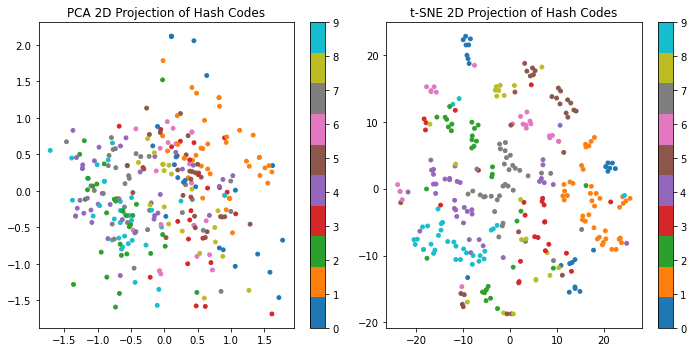

In [59]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality using PCA (to 2 dimensions)
pca = PCA(n_components=2)
hash_codes_2d_pca = pca.fit_transform(hash_codes)

# Reduce dimensionality using t-SNE (for comparison, to 2 dimensions)
tsne = TSNE(n_components=2, random_state=42)
hash_codes_2d_tsne = tsne.fit_transform(hash_codes)

# Plot the 2D PCA projection
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(hash_codes_2d_pca[:, 0], hash_codes_2d_pca[:, 1], c=y_test[0:300], cmap='tab10', s=15)
plt.colorbar()
plt.title("PCA 2D Projection of Hash Codes")

# Plot the 2D t-SNE projection
plt.subplot(1, 2, 2)
plt.scatter(hash_codes_2d_tsne[:, 0], hash_codes_2d_tsne[:, 1], c=y_test[0:300], cmap='tab10', s=15)
plt.colorbar()
plt.title("t-SNE 2D Projection of Hash Codes")

plt.tight_layout()
plt.show()

In [55]:
y_test[0:100]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=uint8)

In [56]:
z

283

In [57]:
hash_codes[0]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1])

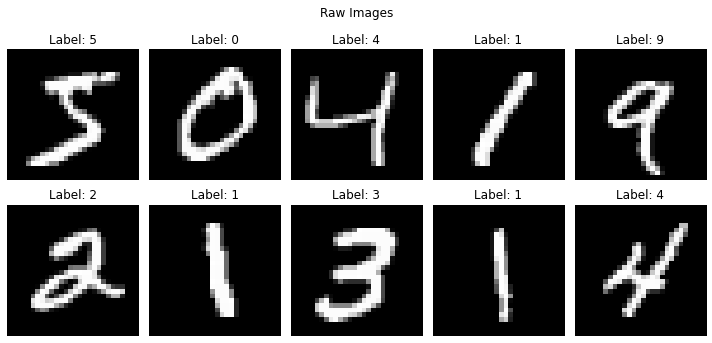

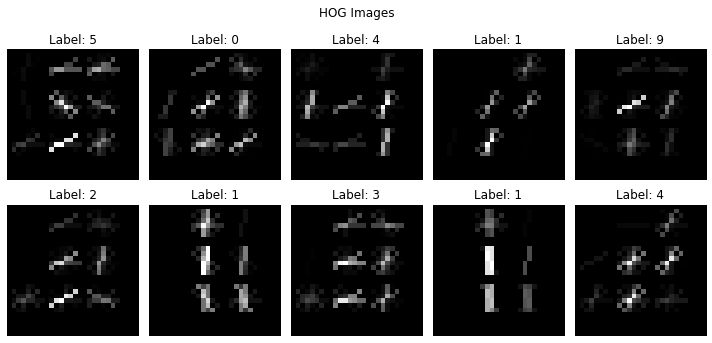

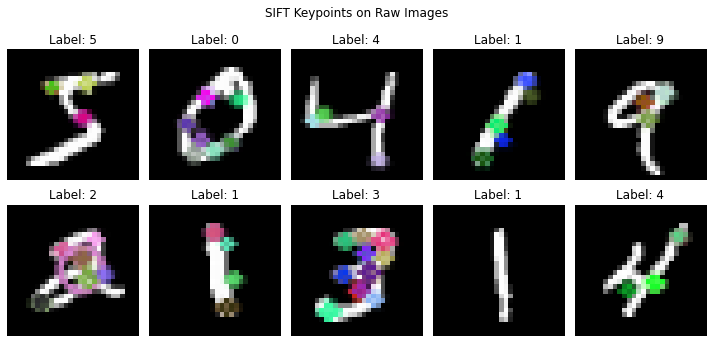

In [12]:

# 3. SIFT FEATURES
def extract_sift_features(images):
    sift = cv2.SIFT_create()  # Create SIFT object
    sift_features = []
    for image in images:
        # Convert image to the format OpenCV expects
        image = np.uint8(image)
        keypoints, descriptors = sift.detectAndCompute(image, None)
        
        # If descriptors are None (no keypoints), just create an empty array
        if descriptors is None:
            descriptors = np.zeros((1, 128))
        
        # Some images will have more keypoints than others, so we pad/truncate to 128 descriptors
        if descriptors.shape[0] < 128:
            descriptors = np.pad(descriptors, ((0, 128 - descriptors.shape[0]), (0, 0)), mode='constant')
        else:
            descriptors = descriptors[:128]
        
        sift_features.append(descriptors.flatten())
    
    return np.array(sift_features)

# Extract SIFT features for training and testing data
x_train_sift = extract_sift_features(x_train)
x_test_sift = extract_sift_features(x_test)

# VISUALIZATION OF RAW, HOG, AND SIFT FEATURES

# Display some raw images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Raw Images")
plt.tight_layout()
plt.show()

# Visualize some HOG images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_hog_images[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("HOG Images")
plt.tight_layout()
plt.show()

# Visualizing SIFT keypoints on original images
plt.figure(figsize=(10, 5))
for i in range(10):
    img = np.uint8(x_train[i])
    keypoints = cv2.SIFT_create().detect(img, None)
    img_sift = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_sift, cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("SIFT Keypoints on Raw Images")
plt.tight_layout()
plt.show()

# Now you have extracted raw, HOG, and SIFT features.
# x_train_raw, x_train_hog, and x_train_sift contain the respective features

In [ ]:
x_train_hog[0]